# Matching Anomalies to Astronomical Intuition

In [1]:
import os
# Set environment variables to disable multithreading
# as users will probably want to set the number of cores
# to the max of their computer.
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


In [2]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from anomaly.constants import GALAXY_LINES
from anomaly.utils import specobjid_to_idx
from astroExplain.spectra.notebook import (
    interpret,
    explain_reconstruction_score,
)
from autoencoders.ae import AutoEncoder
from sdss.metadata import MetaData
from sdss.utils.managefiles import FileDirectory

meta = MetaData()

In [3]:
def explanation_name(lime_config: dict, fudge_config: dict) -> str:

    segmentation = lime_config["segmentation"]
    n_segments = lime_config["number_segments"]
    perturbation = fudge_config["kind_of_fudge"]

    explanation_str = f"{segmentation}_{n_segments}_{perturbation}"

    if perturbation == "scale":

        scale_factor = fudge_config["scale_factor"]
        explanation_str = f"{explanation_str}_{scale_factor}"

    return explanation_str

# Data ingestion

In [4]:
data_dir = "/home/elom/spectra"
model_dir = "/home/elom/models"
bin_id = "bin_03"
explanations_dir = f"{model_dir}/{bin_id}/explanation"

In [5]:
meta_data_df = pd.read_csv(
    f"{data_dir}/0_01_z_0_5_4_0_snr_inf.csv.gz",
    index_col="specobjid",
)

In [6]:
wave = np.load(f"{data_dir}/wave_spectra_imputed.npy")

spectra = np.load(
    f"{data_dir}/spectra_imputed.npy",
    mmap_mode="r"
)

idx_id = np.load(
    f"{data_dir}/{bin_id}/{bin_id}_index_specobjid.npy"
)

## Load model

In [7]:
ae_model = AutoEncoder(
    reload=True,
    reload_from=f"{model_dir}/{bin_id}",
)

# MSE

In [8]:
# Load data frame with anomalies
anomaly_from_score = "mse_noRel100"
mse_noRl100_anomalies_df = pd.read_csv(
    f"{data_dir}/{bin_id}/{anomaly_from_score}/top_anomalies.csv.gz",
    index_col="specobjid",
)


## Strong emission lines

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=3240467000396376064&apid=


ValueError: Using relative units for width or height requires to provide a 4-tuple or a `Bbox` instance to `bbox_to_anchor.

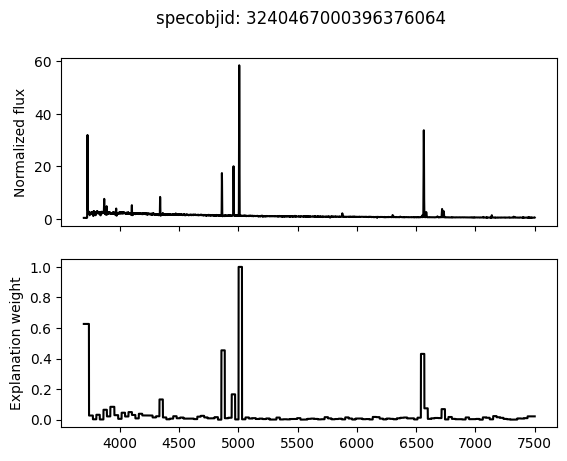

In [ ]:
strong_emission_lines = {
    'specobjid': 3240467000396376064,
    'metric': 'mse_noRel100',
    'explanation': 'uniform_128_scale_0.9',
}

# config file
score_config = {
    "metric": "mse",
    "velocity": 0,
    # if reconstruction
    "relative": False,
    "percentage": 100,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys()),
}

lime_config = {
    "segmentation": "uniform",
    "number_segments": 128,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10_000,
}

fudge_config = {
    "kind_of_fudge": "scale",
    # scale
    "scale_factor": 0.9,
    # control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0,
}

specobjid = strong_emission_lines["specobjid"]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

(
    explanation,
    ret_exp_score,
    ret_exp_local_pred
) = explain_reconstruction_score(
    wave=wave, spectrum=spectrum,
    score_config=score_config,
    lime_config=lime_config,
    fudge_config=fudge_config,
    model=ae_model
)

fig, axs = interpret(
    wave, explanation=explanation, positive=0, negative=0, figsize=None
)
print(meta.get_sky_server_url(specobjid))

fig.suptitle(f"specobjid: {specobjid}")

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.image as mpimg

path_to_image = "/home/elom/phd/00_paper_explain-me-why/sections/figures/astro_intuition_xai/mse/3240467000396376064_mse_noRel100.jpeg"
# Load the image
img = mpimg.imread(path_to_image)

# Create inset in top-right corner of axs[0]
axins = inset_axes(
    axs[0],
    width="30%", height="30%",
    bbox_to_anchor=(0.75, 0.65, 1, 1),  # x0, y0, width, height
    bbox_transform=axs[0].transAxes,
    loc="upper right"
    )

# Show image in the inset
axins.imshow(img)
axins.axis('off')  # Hide axis around the image
fig.tight_layout()

# # save_to = "/home/edgar/explain-me-why/sections/figures/explanations"
# # FileDirectory.check_directory(save_to, exit_program=False)
from_score = strong_emission_lines["metric"]
explanation_str = explanation_name(lime_config, fudge_config)
print(explanation_str)
# # fig.savefig(
# #     f"{save_to}/{specobjid}_{anomaly_from_score}_{explanation_Str}.pdf"
# # )

## bad data reduction

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=637325355518027776&apid=
uniform_64_scale_0.9


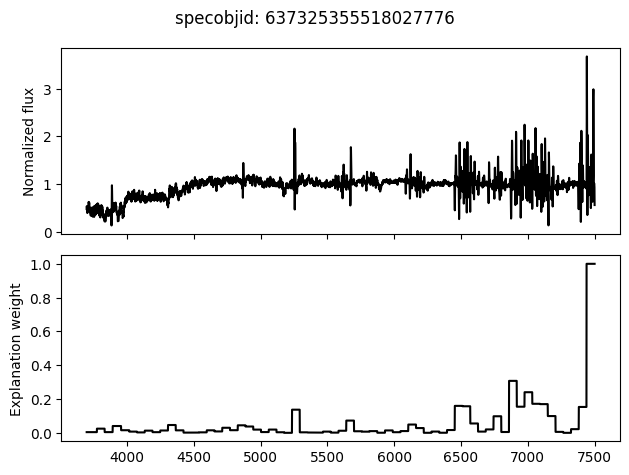

In [10]:
bad_data = {
    'specobjid': 637325355518027776,
    'metric': 'mse_noRel100',
    'explanation': 'uniform_64_scale_0.9',
}

# config file
score_config = {
    "metric": "mse",
    "velocity": 0,
    # if reconstruction
    "relative": False,
    "percentage": 100,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys()),
}

lime_config = {
    "segmentation": "uniform",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10_000,
}

fudge_config = {
    "kind_of_fudge": "scale",
    # scale
    "scale_factor": 0.9,
    # control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0,
}

specobjid = bad_data["specobjid"]

idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

(
    explanation,
    ret_exp_score,
    ret_exp_local_pred
) = explain_reconstruction_score(
    wave=wave, spectrum=spectrum,
    score_config=score_config,
    lime_config=lime_config,
    fudge_config=fudge_config,
    model=ae_model
)

fig, axs = interpret(
    wave, explanation=explanation, positive=0, negative=0, figsize=None
)
print(meta.get_sky_server_url(specobjid))

fig.suptitle(f"specobjid: {specobjid}")
fig.tight_layout()

# # save_to = "/home/edgar/explain-me-why/sections/figures/explanations"
# # FileDirectory.check_directory(save_to, exit_program=False)
from_score = bad_data["metric"]
explanation_str = explanation_name(lime_config, fudge_config)
print(explanation_str)
# # fig.savefig(
# #     f"{save_to}/{specobjid}_{anomaly_from_score}_{explanation_Str}.pdf"
# # )

# MSE after ignoring 3%

In [61]:
# # Load data frame with anomalies
# anomaly_from_score = "mse_noRel97"
# mse_noRel97_anomalies_df = pd.read_csv(
#     f"{data_dir}/{bin_id}/{anomaly_from_score}/top_anomalies.csv.gz",
#     index_col="specobjid",
# )


## Blue shaped spectrum with absorsiton lines

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=531492683672217600&apid=
uniform_64_scale_0.9


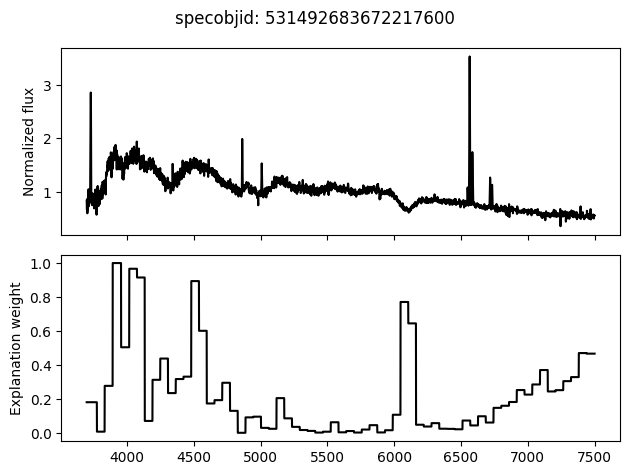

In [11]:
blue_shape = {
    'specobjid': 531492683672217600,
    'metric': 'mse_noRel97',
    'explanation': 'uniform_64_scale_0.9',
}

# config file
score_config = {
    "metric": "mse",
    "velocity": 0,
    # if reconstruction
    "relative": False,
    "percentage": 97,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys()),
}
lime_config = {
    "segmentation": "uniform",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000,
}
fudge_config = {
    "kind_of_fudge": "scale",
    # scale
    "scale_factor": 0.9,
    # control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0,
}

specobjid = blue_shape["specobjid"]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

(
    explanation,
    ret_exp_score,
    ret_exp_local_pred
) = explain_reconstruction_score(
    wave=wave, spectrum=spectrum,
    score_config=score_config,
    lime_config=lime_config,
    fudge_config=fudge_config,
    model=ae_model
)

fig, axs = interpret(
    wave, explanation=explanation, positive=0, negative=0, figsize=None
)
print(meta.get_sky_server_url(specobjid))

fig.suptitle(f"specobjid: {specobjid}")
fig.tight_layout()

# save_to = "/home/edgar/explain-me-why/sections/figures/explanations"
# FileDirectory.check_directory(save_to, exit_program=False)
explanation_str = explanation_name(lime_config, fudge_config)
print(explanation_str)
anomaly_from_score = blue_shape["metric"]

# fig.savefig(
#     f"{save_to}/{specobjid}_{anomaly_from_score}_{explanation_Str}.pdf"
# )

## Star

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=1780176998165932032&apid=
uniform_64_scale_0.9


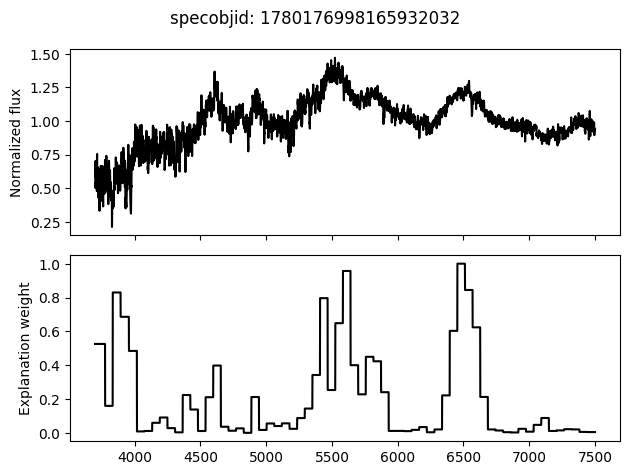

In [12]:
star = {
    'specobjid': 1780176998165932032,
    'metric': 'mse_noRel97',
    'explanation': 'uniform_64_scale_0.9',
}

# config file
score_config = {
    "metric": "mse",
    "velocity": 0,
    # if reconstruction
    "relative": False,
    "percentage": 97,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys()),
}
lime_config = {
    "segmentation": "uniform",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10_000,
}
fudge_config = {
    "kind_of_fudge": "scale",
    # scale
    "scale_factor": 0.9,
    # control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0,
}

specobjid = star["specobjid"]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

(
    explanation,
    ret_exp_score,
    ret_exp_local_pred
) = explain_reconstruction_score(
    wave=wave, spectrum=spectrum,
    score_config=score_config,
    lime_config=lime_config,
    fudge_config=fudge_config,
    model=ae_model
)

fig, axs = interpret(
    wave, explanation=explanation, positive=0, negative=0, figsize=None
)
print(meta.get_sky_server_url(specobjid))

fig.suptitle(f"specobjid: {specobjid}")
fig.tight_layout()

# save_to = "/home/edgar/explain-me-why/sections/figures/explanations"
# FileDirectory.check_directory(save_to, exit_program=False)
explanation_str = explanation_name(lime_config, fudge_config)
print(explanation_str)
# fig.savefig(
#     f"{save_to}/{specobjid}_{anomaly_from_score}_{explanation_Str}.pdf"
# )

# MSE with 250 kms-1 filter

```python
broad_line = {
    'specobjid':1924292192684238848 ,
    'metric': 'mse_filter_250kms_noRel100',
    'explanation': 'uniform_128_scale_0.9',
}

cosmic = {
    'specobjid': 407686575611209728,
    'metric': 'mse_filter_250kms_noRel100',
    'explanation': 'uniform_64_scale_0.9',
}
```

## Broad line and strong emission

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=1924292192684238848&apid=
uniform_128_scale_0.9


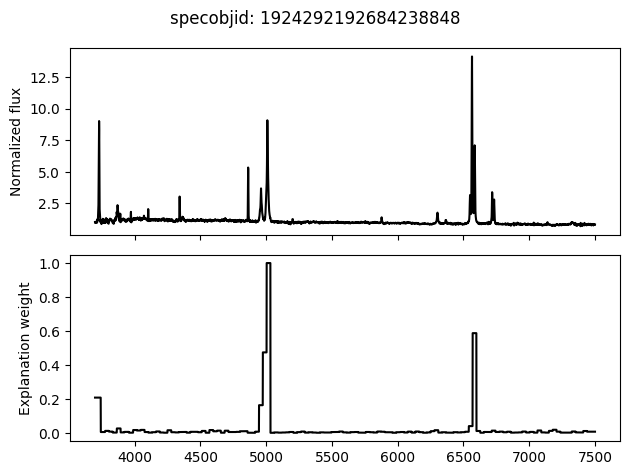

In [13]:
broad_line = {
    'specobjid':1924292192684238848 ,
    'metric': 'mse_filter_250kms_noRel100',
    'explanation': 'uniform_128_scale_0.9',
}

# config file
score_config = {
    "metric": "mse",
    "velocity": 250,
    # if reconstruction
    "relative": False,
    "percentage": 100,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys()),
}
lime_config = {
    "segmentation": "uniform",
    "number_segments": 128,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000,
}
fudge_config = {
    "kind_of_fudge": "scale",
    # scale
    "scale_factor": 0.9,
    # control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0,
}

specobjid = broad_line["specobjid"]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

(
    explanation,
    ret_exp_score,
    ret_exp_local_pred
) = explain_reconstruction_score(
    wave=wave, spectrum=spectrum,
    score_config=score_config,
    lime_config=lime_config,
    fudge_config=fudge_config,
    model=ae_model
)

fig, axs = interpret(
    wave, explanation=explanation, positive=0, negative=0, figsize=None
)
print(meta.get_sky_server_url(specobjid))

fig.suptitle(f"specobjid: {specobjid}")
fig.tight_layout()

# save_to = "/home/edgar/explain-me-why/sections/figures/explanations"
# FileDirectory.check_directory(save_to, exit_program=False)
explanation_str = explanation_name(lime_config, fudge_config)
print(explanation_str)
# fig.savefig(
#     f"{save_to}/{specobjid}_{anomaly_from_score}_{explanation_Str}.pdf"
# )

## Spectrum with a glitch

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=407686575611209728&apid=
uniform_128_scale_0.9


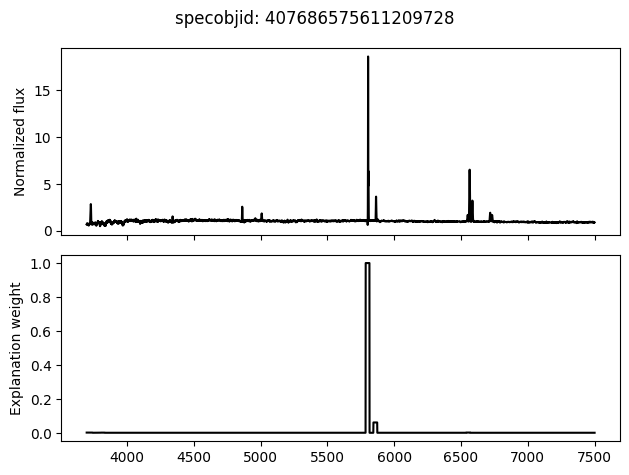

In [14]:
cosmic = {
    'specobjid': 407686575611209728,
    'metric': 'mse_filter_250kms_noRel100',
    'explanation': 'uniform_64_scale_0.9',
}

# config file
score_config = {
    "metric": "mse",
    "velocity": 250,
    # if reconstruction
    "relative": False,
    "percentage": 100,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys()),
}
lime_config = {
    "segmentation": "uniform",
    "number_segments": 128,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000,
}
fudge_config = {
    "kind_of_fudge": "scale",
    # scale
    "scale_factor": 0.9,
    # control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0,
}

specobjid = cosmic["specobjid"]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

(
    explanation,
    ret_exp_score,
    ret_exp_local_pred
) = explain_reconstruction_score(
    wave=wave, spectrum=spectrum,
    score_config=score_config,
    lime_config=lime_config,
    fudge_config=fudge_config,
    model=ae_model
)

fig, axs = interpret(
    wave, explanation=explanation, positive=0, negative=0, figsize=None
)
print(meta.get_sky_server_url(specobjid))

fig.suptitle(f"specobjid: {specobjid}")
fig.tight_layout()

# save_to = "/home/edgar/explain-me-why/sections/figures/explanations"
# FileDirectory.check_directory(save_to, exit_program=False)
explanation_str = explanation_name(lime_config, fudge_config)
print(explanation_str)
# fig.savefig(
#     f"{save_to}/{specobjid}_{anomaly_from_score}_{explanation_Str}.pdf"
# )

# MSE with 250 kms-1 filter after ignoring 3%

## broad near H alpha

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=2664004586678806528&apid=
uniform_64_scale_0.9


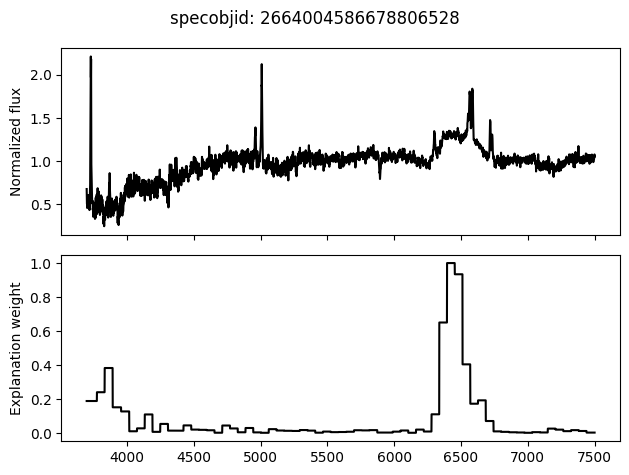

In [15]:
broad_near_halpha = {
    'specobjid': 2664004586678806528,
    'metric': 'mse_filter_250kms_noRel97',
    'explanation': 'uniform_64_scale_0.9',
}

# config file
score_config = {
    "metric": "mse",
    "velocity": 250,
    # if reconstruction
    "relative": False,
    "percentage": 100,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys()),
}
lime_config = {
    "segmentation": "uniform",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000,
}
fudge_config = {
    "kind_of_fudge": "scale",
    # scale
    "scale_factor": 0.9,
    # control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0,
}

specobjid = broad_near_halpha["specobjid"]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

(
    explanation,
    ret_exp_score,
    ret_exp_local_pred
) = explain_reconstruction_score(
    wave=wave, spectrum=spectrum,
    score_config=score_config,
    lime_config=lime_config,
    fudge_config=fudge_config,
    model=ae_model
)

fig, axs = interpret(
    wave, explanation=explanation, positive=0, negative=0, figsize=None
)
print(meta.get_sky_server_url(specobjid))

fig.suptitle(f"specobjid: {specobjid}")
fig.tight_layout()

# save_to = "/home/edgar/explain-me-why/sections/figures/explanations"
# FileDirectory.check_directory(save_to, exit_program=False)
explanation_str = explanation_name(lime_config, fudge_config)
print(explanation_str)
# fig.savefig(
#     f"{save_to}/{specobjid}_{anomaly_from_score}_{explanation_Str}.pdf"
# )

## bumpy spectrum

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=2501881598136313856&apid=
uniform_64_scale_0.9


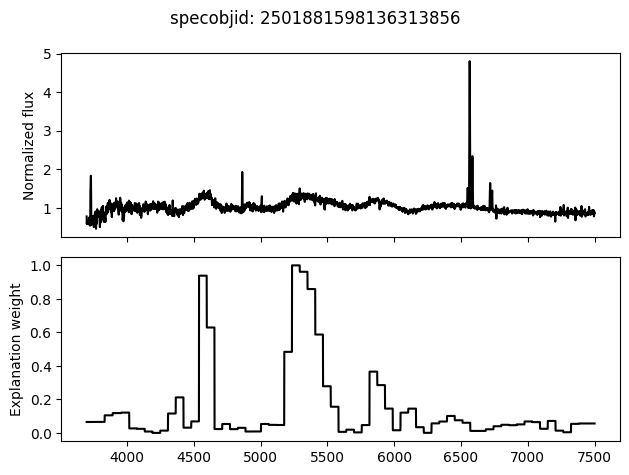

In [16]:
bumpy = {
    'specobjid': 2501881598136313856,
    'metric': 'mse_filter_250kms_noRel97',
    'explanation': 'uniform_64_scale_0.9',
}
# config file
score_config = {
    "metric": "mse",
    "velocity": 250,
    # if reconstruction
    "relative": False,
    "percentage": 100,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys()),
}
lime_config = {
    "segmentation": "uniform",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000,
}
fudge_config = {
    "kind_of_fudge": "scale",
    # scale
    "scale_factor": 0.9,
    # control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0,
}

specobjid = bumpy["specobjid"]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

(
    explanation,
    ret_exp_score,
    ret_exp_local_pred
) = explain_reconstruction_score(
    wave=wave, spectrum=spectrum,
    score_config=score_config,
    lime_config=lime_config,
    fudge_config=fudge_config,
    model=ae_model
)

fig, axs = interpret(
    wave, explanation=explanation, positive=0, negative=0, figsize=None
)
print(meta.get_sky_server_url(specobjid))

fig.suptitle(f"specobjid: {specobjid}")
fig.tight_layout()

# save_to = "/home/edgar/explain-me-why/sections/figures/explanations"
# FileDirectory.check_directory(save_to, exit_program=False)
explanation_str = explanation_name(lime_config, fudge_config)
print(explanation_str)
# fig.savefig(
#     f"{save_to}/{specobjid}_{anomaly_from_score}_{explanation_Str}.pdf"
# )